## 支持向量机

In [1]:
import numpy as np
np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] # 鸢尾花 长 宽
y = iris["target"]

# 两种类型
setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier Model --> SVC
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

SVC(C=inf, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

https://cloud.tencent.com/developer/article/1146077
* support_:以数组的形式返回支持向量的索引。   
* support_vectors_:返回支持向量。   
* n_support_:每个类别支持向量的个数。
* dual_coef_:支持向量系数。
* coef_:每个特征系数（重要性），只有核函数是LinearSVC的时候可用。
* intercept_:截距值（常数值）。

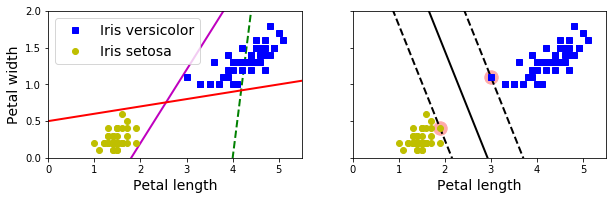

In [3]:
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

# 假设函数 h(x) = wx + b
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]
    
    # w0*x0 + w1*x1 + b = 0
    # x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]
    
#     print( w, b, decision_boundary)
    
    # 为什么这里是这个 Margin的计算方式
    # w0*x0 + w1*x1 + b = -1  --> -w0/w1 * x0 - b/w1 - 1/w1
    # w0*x0 + w1*x1 + b = 1  --> -w0/w1 * x0 - b/w1 + 1/w1
    # decision_boundary = -w0/w1 * x0 - b/w1 替换后获得
    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    
    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors="#FFAAAA")
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)
plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

我们注意到添加更多的样本点在“街道”外并不会影响到判定边界，因为判定边界是由位于“街道”边缘的样本点确定的，这些样本点被称为“支持向量”（图中被圆圈圈起来的点）

### SVM 对特征缩放比较敏感

[-2, 2, -2, 2]

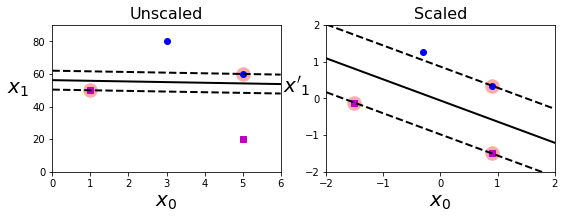

In [4]:
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

plt.figure(figsize=(9,2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$    ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x'_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

In [5]:
print(Xs[:, 0], Xs[:, 0][ys==1])

[1. 5. 3. 5.] [3. 5.]


### 软间隔分类 Soft Margin Classification
如果我们严格地规定所有的数据都不在“街道”上，都在正确地两边，称为硬间隔分类。有两个问题：
1. 只对线性可分的数据起作用
2. 对异常点敏感。 

为了避免上述的问题，我们更倾向于使用更加软性的模型。目的在保持“街道”尽可能大和避免*间隔违规(margin violations)*（例如：数据点出现在“街道”中央或者甚至在错误的一边）之间找到一个良好的平衡。这就是软间隔分类。

In [6]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

In [7]:
# svm 只是会输出0和1， 不会输出对应的分数
svm_clf.predict([[5.5, 1.7]])

array([1.])

In [8]:
# https://blog.csdn.net/fendegao/article/details/79968994  理解Hinge Loss
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

/Users/xiangyue/miniconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

In [9]:
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
# 由于决策边界是 = 0，正好这个值是0 1， 乘2减1 后正好转换为 -1 和 1 然后计算与决策边界 距离小于1 的是支持向量
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

[4, 5.9, 0.8, 2.8]

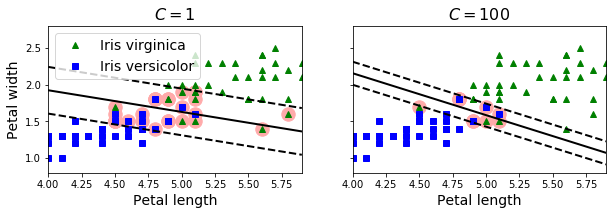

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])


### 非线性支持向量机分类  Nonlinear SVM Classification   
![image.png](images/05_nonlinear_svc.png)
上图中的样本不是线性可分的，这时候可以使用多项式函数变换去做分类

In [11]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15)

polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
])

polynomial_svm_clf.fit(X, y)

/Users/xiangyue/miniconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

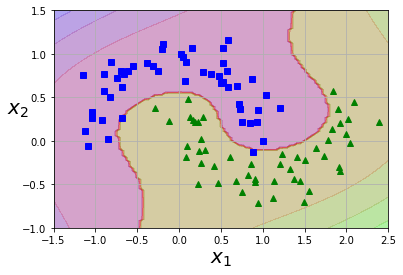

In [12]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
#     print(type(x0), type(x1), x0.shape, x1.shape)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.2)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

### Polynomial Kernel 
当你使用 SVM 时，你可以运用一个被称为“核技巧”（kernel trick）的神奇数学技巧。它可以取得就像你添加了许多多项式，甚至有高次数的多项式，一样好的结果。所以不会大量特征导致的组合爆炸，因为你并没有增加任何特征。

In [13]:
from sklearn.svm import SVC
poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5)) # 超参数coef0控制了高阶多项式与低阶多项式对模型的影响。
])
poly_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

Text(0.5, 1.0, '$d=3, coef0=1, C=5$')

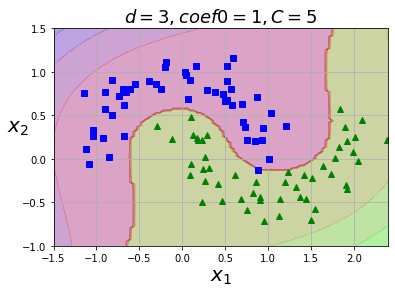

In [14]:
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, coef0=1, C=5$", fontsize=18)

In [15]:
poly100_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5)) # 超参数coef0控制了高阶多项式与低阶多项式对模型的影响。
])
poly100_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=100,
  decision_function_shape='ovr', degree=10, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

Text(0.5, 1.0, '$d=10, coef0=100, C=5$')

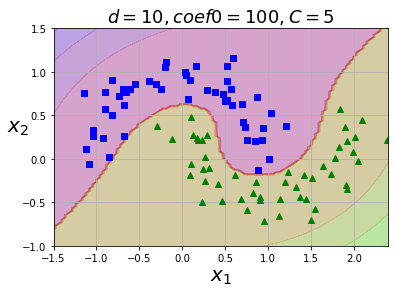

In [16]:
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, coef0=100, C=5$", fontsize=18)

### 增加相似特征   Similarity Features
另一种解决非线性问题的方法是使用相似函数（similarity funtion）计算每个样本与特定地标（landmark）的相似度。
RBF径向基函数：是一个取值仅仅依赖于离原点距离的实值函数， https://blog.csdn.net/qq_15295565/article/details/80888607   
高斯径向基函数：   
$
{\displaystyle \phi_{\gamma}(\mathbf{x}, \boldsymbol{\ell})} = {\displaystyle \exp({\displaystyle -\gamma \left\| \mathbf{x} - \boldsymbol{\ell} \right\|^2})}
$   
![image.png](images/05_similarity_features.png)
上图所有的样本不是线性可分的，使用径向基函数进行变换。   
首先定义两个地标 x1 = –2 和 x1 = 1，对于 X 进行变换获得 x2 = exp(–0.3 × 12) ≈ 0.74 和 x3 = exp(–0.3 × 22) ≈ 0.30，然后转换成右图，这样就可以线性可分了。

#### 如何选择地标?
最简单的方法是在数据集中的每一个样本的位置创建地标。这将产生更多的维度从而增加了转换后数据集是线性可分的可能性。

In [17]:
rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001)) # gamma (γ) 上面函数中的
])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

![image.png](images/05_rbf_kernel.png)

### 时间复杂度 Time Complexity
![image.png](images/05_time_complexity.png)

### SVM Regression

In [18]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [21]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)  # epsilon The width of the street is controlled by a hyperparameter, ϵ.
svm_reg.fit(X, y)

svm_reg.predict([[22]])

array([69.37486626])

In [24]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])
eps_y_pred

array([6.52640746])

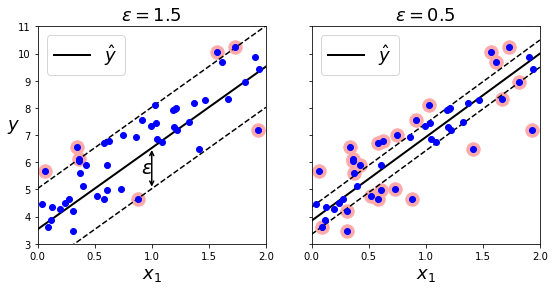

In [25]:
def plot_svm_regression(svm_reg, X, y, axes):
    xls = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(xls)
    plt.plot(xls, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(xls, y_pred + svm_reg.epsilon, "k--")
    plt.plot(xls, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors="#FFAAAA")
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
plt.show()

In [27]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

In [28]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X, y)

SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [29]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

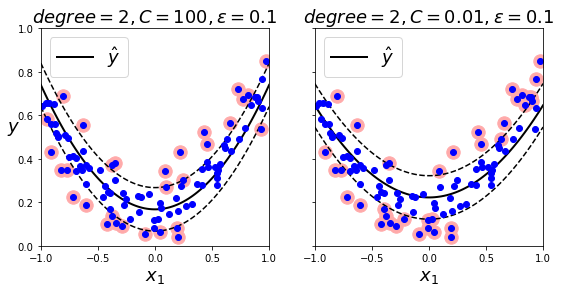

In [30]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
plt.show()